In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.circuit.library.standard_gates import RYGate, PhaseGate
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def execute_circuit(qc, shots=1024, device=None):
    device = Aer.get_backend('qasm_simulator') if device is None else device
    transpiled_circuit = transpile(qc, device)
    counts = device.run(transpiled_circuit, shots=shots).result().get_counts()
    return counts

def basis_states_probs(counts):
    n = len(list(counts.keys())[0])
    N = sum(list(counts.values()))
    return np.array([counts[np.binary_repr(vals,n)]/N if counts.get(np.binary_repr(vals,n)) is not None else 0 for vals in range(2**n)])


In [3]:
def eH_mixer(n_qubits,beta,i):
    q_register = QuantumRegister(n_qubits)
    qc = QuantumCircuit(q_register,name=f'$\\beta_{i}$\n$H_m$')
    [qc.rx(2*beta,q) for q in q_register]
    return qc.to_gate()

In [4]:
def init_state(n_qubits):
    q_register = QuantumRegister(n_qubits)
    qc = QuantumCircuit(q_register,name=f'init')
    [qc.h(q) for q in q_register]
    return qc

In [5]:
def eH_particle_ring(n_qubits,alpha,i):
    q_register = QuantumRegister(n_qubits)
    qc = QuantumCircuit(q_register,name=f'$\\alpha_{i}$\n$H_c$')
    for n in range(1,2**n_qubits):
        #for j in range(n_qubits-1):
        j = 0
        qc.append(PhaseGate(-n*alpha*(-1)**(n%2)).control(num_ctrl_qubits=n_qubits-1-j,ctrl_state=np.binary_repr(n,n_qubits)[:-j-1]),list(range(j+1,n_qubits))+[j])
        [qc.append(PhaseGate(-n*alpha*(-1)**(n%2)),[x]) for x in range(1,n_qubits)]
    return qc.to_gate()

In [7]:
def QAOA(n_qubtis,initial_state,mixer,cost,f,N):
    q_register = QuantumRegister(n_qubtis)
    qc = QuantumCircuit(q_register,name='QAOA')
    qc.append(initial_state(n_qubtis),q_register)
    for p in range(N):
        alpha,beta = f(p,N)
        qc.append(cost(n_qubtis,alpha,p),q_register)
        qc.append(mixer(n_qubtis,beta,p),q_register)
    qc.measure_all()
    return qc

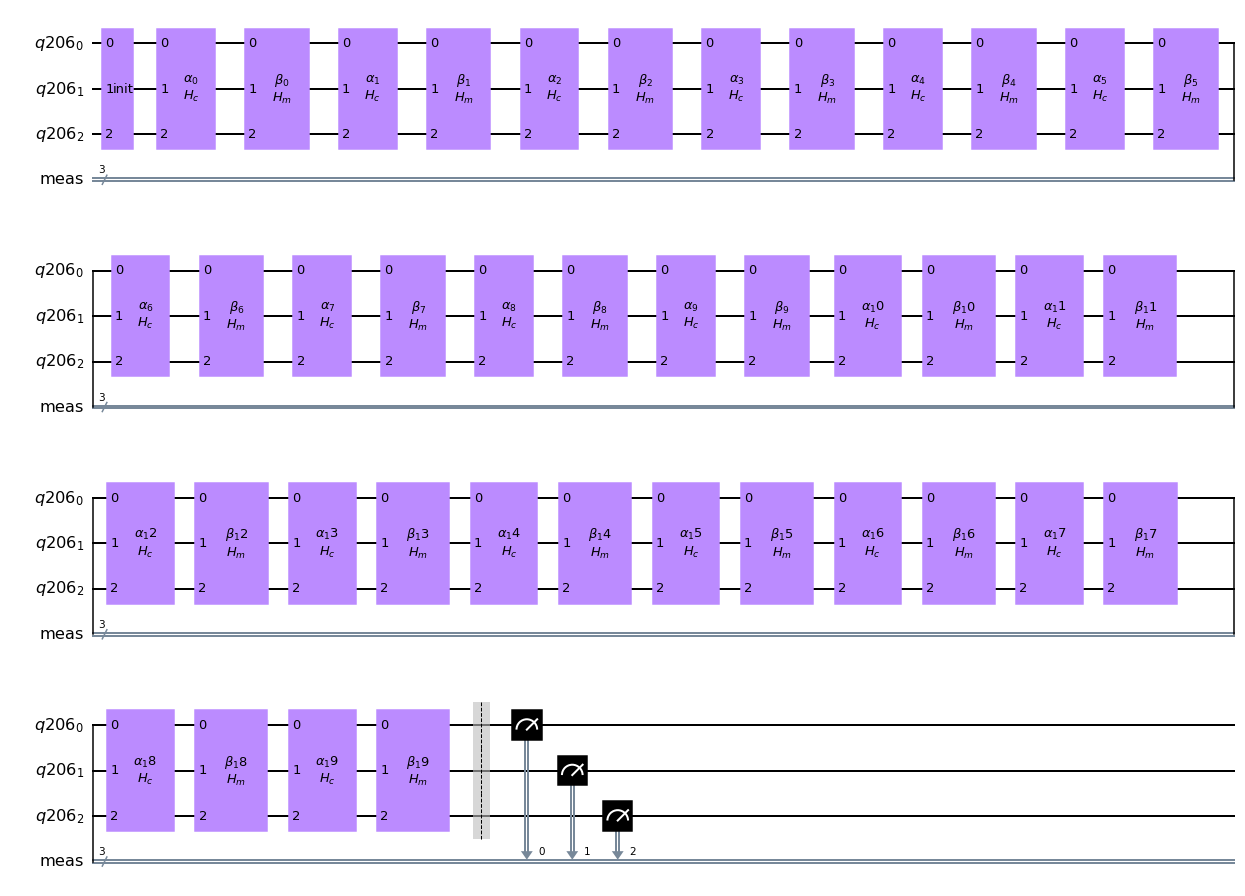

In [19]:
linear = lambda p,N: (p/N,1-p/N)

n_qubits =3
N = 20

qc = QAOA(n_qubits,init_state,eH_mixer,eH_particle_ring,linear,N)
qc.draw(output='mpl')

In [20]:
res = basis_states_probs(execute_circuit(qc))
print(res)

[9.99023438e-01 0.00000000e+00 9.76562500e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


In [12]:
def get_angle(s,j, x):
    a=0
    b=0
    for l in range(2**(s-1)):
        a+=x[(2*j - 1)*(2**(s-1)) + l]
    for l in range(2**s):
        b+=x[(j - 1)*(2**s) + l]
    if b==0:
        return 0
    else:
        return 2*np.arcsin(np.sqrt(a/b))

def mottonen(x):
    n_qubits = int(np.ceil(np.log2(len(x))))
    x = x/np.sum(x) if n_qubits == np.log2(len(x)) else np.array(list(x)+[0 for _ in range(len(x),2**n_qubits)])/np.sum(x)
    qc = QuantumCircuit(n_qubits)
    qc.append(RYGate(-get_angle(n_qubits,1,x)),[n_qubits-1])
    for s in range(n_qubits-2,-1,-1):        
        [qc.append(RYGate(-get_angle(s+1,j+1,x)).control(n_qubits-s-1,ctrl_state=np.binary_repr(j,n_qubits-s-1)),list(range(s+1,n_qubits))+[s]) for j in range(2**(n_qubits-s-1)-1,-1,-1)]
    return qc

In [16]:
H  = lambda b: np.sum([(c=='1')*1 for c in np.binary_repr(b)])%2

def H_particle_ring(init_state,V=0):
    n_qubits = int(np.ceil(np.log2(len(init_state))))
    N_energies = int(2**n_qubits)
    qc = mottonen(init_state)
    qc.measure_all()
    display(qc.draw(output='mpl'))
    probs = basis_states_probs(execute_circuit(qc))
    exp_z = np.sum(probs[::2])-np.sum(probs[1::2])
    exp_projetors = dict(zip([np.binary_repr(n,n_qubits-1) for n in range(2**(n_qubits-1))],probs[::2]+probs[1::2]))

    energy = 0
    for n in range(1,N_energies):
        n_binary = np.binary_repr(n,n_qubits)
        E = exp_projetors[n_binary[:-1]]*(1+(-1)**(n%2)*exp_z)*n**2/2
        energy += E

    return energy+V

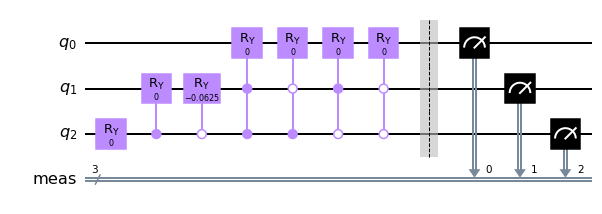

0.0078125

In [21]:
H_particle_ring(res)